In [39]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [40]:
k = 0.47       # Thermal conductivity (W/m.K)
rho = 1573     # Density (kg/m^3)
Cp = 967       # Specific heat capacity (J/kg.K)
alpha = k / (rho * Cp)  # Thermal diffusivity (m^2/s)

# Geometry and time
L = 0.01       # Thickness of the part (m)
T_inf = 50     # Ambient air temperature (°C)
T0 = 0         # Initial temperature (°C)
h1 = 100       # Convective heat transfer coefficient (top surface, W/m^2K)
h2 = 50        # Convective heat transfer coefficient (bottom surface, W/m^2K)


In [ ]:
# Creating a mesh grid for x (position) and t (time)
x = np.linspace(0, L, 100)
t = np.linspace(0, 600, 100)
X, T = np.meshgrid(x, t)

train_x = X.flatten().reshape(-1, 1)
train_t = T.flatten().reshape(-1, 1)
train_x = tf.convert_to_tensor(train_x, dtype=tf.float32)
train_t = tf.convert_to_tensor(train_t, dtype=tf.float32)
train_data = np.hstack((train_x, train_t))


In [ ]:
def loss_fn(model, x, t):
    """
    Computes the loss for the PINN, including:
    - PDE residual
    - Boundary conditions
    - Initial condition
    """
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([x, t])
        inputs = tf.concat([x, t], axis=1)
        u = model(inputs)

        # First-order derivatives
        u_t = tape1.gradient(u, t)
        u_x = tape1.gradient(u, x)

    # Second-order derivative (u_xx)
    u_xx = tape1.gradient(u_x, x)
    del tape1  # Release resources after computing the required derivatives

    # PDE Residual Loss: du/dt - alpha * d²u/dx² = 0
    pde_loss = tf.reduce_mean(tf.square(u_t - alpha * u_xx))

    # Boundary Conditions Loss
    # Top surface (x=0)
    bc1_loss = tf.reduce_mean(tf.square(h1 * (T_inf - u) - k * u_x))
    # Bottom surface (x=L)
    bc2_loss = tf.reduce_mean(tf.square(h2 * (T_inf - u) - k * u_x))

    # Initial Condition Loss: u(x, t=0) = T0
    ic_loss = tf.reduce_mean(tf.square(u - T0))
    
    total_loss = pde_loss + bc1_loss + bc2_loss + ic_loss
    return total_loss



pinn=PINN()

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
epochs = 10000
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        loss = loss_fn(pinn, train_x, train_t)
    gradients = tape.gradient(loss, pinn.trainable_variables)
    optimizer.apply_gradients(zip(gradients, pinn.trainable_variables))

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.numpy()}")


Epoch 0: Loss = 28937572.0
Epoch 100: Loss = 7351120.5
Epoch 200: Loss = 6495620.0
Epoch 300: Loss = 5860826.0
Epoch 400: Loss = 5032485.5
Epoch 500: Loss = 3905254.25
Epoch 600: Loss = 2402990.75
Epoch 700: Loss = 952709.5
Epoch 800: Loss = 382950.0625
Epoch 900: Loss = 262185.9375
Epoch 1000: Loss = 197250.59375
Epoch 1100: Loss = 162693.1875
Epoch 1200: Loss = 139217.265625
Epoch 1300: Loss = 121258.953125
Epoch 1400: Loss = 106871.0078125
Epoch 1500: Loss = 94881.71875
Epoch 1600: Loss = 82787.671875
Epoch 1700: Loss = 73919.328125
Epoch 1800: Loss = 66731.8828125
Epoch 1900: Loss = 60447.734375
Epoch 2000: Loss = 54870.6953125
Epoch 2100: Loss = 49885.30078125
Epoch 2200: Loss = 45362.35546875
Epoch 2300: Loss = 41216.9140625
Epoch 2400: Loss = 37439.734375
Epoch 2500: Loss = 34000.34765625
Epoch 2600: Loss = 30773.0703125
Epoch 2700: Loss = 27727.193359375
Epoch 2800: Loss = 24896.41796875
Epoch 2900: Loss = 22340.53125
Epoch 3000: Loss = 20032.294921875
Epoch 3100: Loss = 17954.

In [ ]:
x_test = np.linspace(0, L, 100).reshape(-1, 1)
t_test = np.linspace(0, 600, 100).reshape(-1, 1)

X_test, T_test = np.meshgrid(x_test, t_test)
test_data = np.hstack((X_test.flatten().reshape(-1, 1), T_test.flatten().reshape(-1, 1)))

test_data = tf.convert_to_tensor(test_data, dtype=tf.float32)

pinn.save_weights('pinn_results.weights.h5')
pinn.load_weights('pinn_results.weights.h5')
predictions = pinn(test_data)

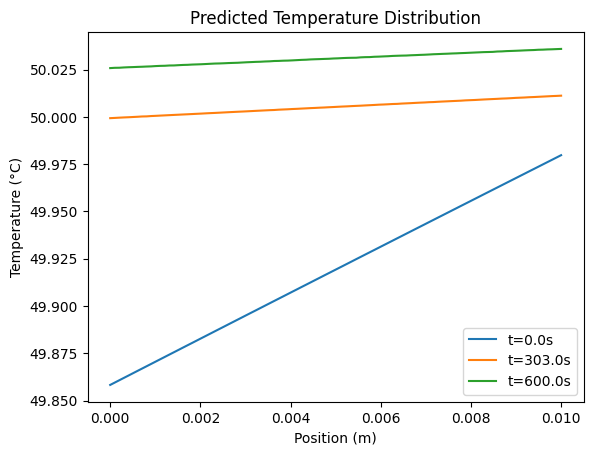

In [ ]:
predicted_temperatures = tf.reshape(predictions, X_test.shape).numpy()

# Plot temperature profiles at different time points
time_indices = [0, 50, 99]
for idx in time_indices:
    plt.plot(x_test, predicted_temperatures[idx, :], label=f"t={t_test[idx, 0]:.1f}s")
plt.xlabel("Position (m)")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.title("Predicted Temperature Distribution")
plt.show()
